<a href="https://colab.research.google.com/github/Mihail-Chr/projects/blob/main/ML/car_cost/ML_car_cost_regression_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении имеются исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. Метрика  RMSE должна быть не ниже 2500

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
! pip install catboost
! pip install phik

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.0/679.0 kB 8.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns


# import phik
from phik.report import plot_correlation_matrix
from phik import phik_matrix

import sklearn.utils
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer,IterativeImputer,SimpleImputer
from sklearn.metrics import (confusion_matrix,mean_squared_error,precision_recall_curve,roc_auc_score,classification_report,
                             r2_score,accuracy_score,make_scorer,f1_score,roc_curve,RocCurveDisplay,
                             mean_absolute_error,recall_score,precision_score,ConfusionMatrixDisplay)

from sklearn.feature_selection import SelectKBest,f_classif, mutual_info_classif
from sklearn.inspection import permutation_importance

from sklearn.model_selection import (train_test_split,GridSearchCV,cross_val_score)

from sklearn.metrics import root_mean_squared_error,mean_absolute_error

from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge, PassiveAggressiveRegressor,SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler,MinMaxScaler,OneHotEncoder,PolynomialFeatures)
from sklearn.pipeline import Pipeline

from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor


from numba import jit, cuda, njit

import warnings
from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')
import sys
import os
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')

#optuna.logging.set_verbosity(optuna.logging.WARNING)

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:,.2f}'.format
pd.DataFrame.iteritems = pd.DataFrame.items
RANDOM_STATE = 255
TEST_SIZE = 0.25
warnings.filterwarnings('ignore')
#pd.options.mode.copy_on_write = True

In [4]:
# функция преобразования в bool

def bul(dat,col,tru,nt):
    dat[col][dat[col]==tru]=1
    dat[col][dat[col]==nt]=0
    #dat[col]=dat[col].astype('boolean')
    #voc_k[col]=(nt,tru)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Обработка данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
count,"326,826.00",291577,"326,826.00",309248,"326,826.00",308294,"326,826.00","326,826.00",295704,326826,260399
unique,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2
top,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no
freq,NaN,83602,NaN,248135,NaN,26444,NaN,NaN,200260,69992,225970
mean,"4,403.75",NaN,"2,004.23",NaN,110.24,NaN,"128,144.07",5.70,NaN,NaN,NaN
std,"4,518.21",NaN,91.12,NaN,195.89,NaN,"37,947.66",3.72,NaN,NaN,NaN
min,0.00,NaN,"1,000.00",NaN,0.00,NaN,"5,000.00",0.00,NaN,NaN,NaN
25%,"1,000.00",NaN,"1,999.00",NaN,69.00,NaN,"125,000.00",3.00,NaN,NaN,NaN
50%,"2,700.00",NaN,"2,003.00",NaN,105.00,NaN,"150,000.00",6.00,NaN,NaN,NaN
75%,"6,350.00",NaN,"2,008.00",NaN,141.00,NaN,"150,000.00",9.00,NaN,NaN,NaN


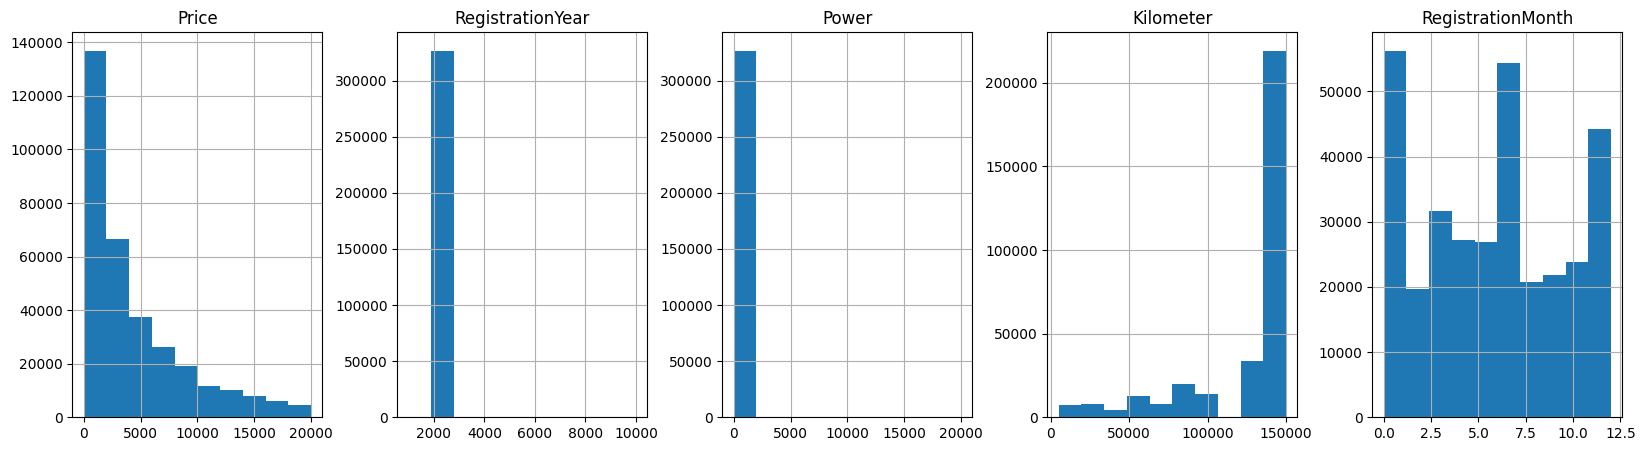

In [6]:
avto_df = pd.read_csv('/content/drive/MyDrive/data/autos.csv')
avto_df.info()
display(avto_df.head())

# удаляем столбцы с "технической информацией"
del_col = ['DateCrawled','DateCreated','NumberOfPictures','PostalCode','LastSeen']
avto_df = avto_df.drop(del_col, axis=1).copy()

# удаляем дубликаты
avto_df = avto_df.drop_duplicates()

display(avto_df.describe(include = "all"))

avto_df1 = avto_df.copy()
avto_df.hist(figsize=(20, 5), layout = (-1, 5))
plt.show()

### Первичные выводы:
 - наблюдается аномалии в годе выпуска, мощности
 - месяцев 13, вместо 12
 - нужно исследовать авто , стоимостью около 0
 - нужно исследовать авто , мощностью около 0
 - исследовать значения года больше текущего
 - исследовать мощность более "реальной" (650 л.с.)

In [7]:
#произведем отчистку от нереалистичных данных

# удалим авто с RegistrationYear <1986 и > 2016
avto_df = avto_df1.copy()
avto_df = avto_df[(avto_df['RegistrationYear']>1986) & (avto_df['RegistrationYear']<2016)].copy()

# удалим авто с мощность <50 и >650
avto_df = avto_df[(avto_df['Power']>10) & (avto_df['Power']<650)].copy()

# удалим авто с ценой  <50
avto_df = avto_df[(avto_df['Price']>100)].copy()

# объединим признак "по газу"
avto_df = avto_df.replace('lpg', 'gasoline').copy()
avto_df = avto_df.replace('cng', 'gasoline').copy()

display('количество пустых ячеек',avto_df.isnull().sum())
#avto_df.info()
#avto_df.head()

'количество пустых ячеек'

,0
Price,0
VehicleType,4250
RegistrationYear,0
Gearbox,4430
Power,0
Model,9030
Kilometer,0
RegistrationMonth,0
FuelType,12056
Brand,0


In [8]:
# анализ категориальных признаков
for col in avto_df.columns:
    if avto_df[col].isnull().sum()!=0 :
        display(avto_df[col].value_counts(dropna=False))

,count
VehicleType,
sedan,74283
small,63107
wagon,53889
bus,24112
convertible,16786
coupe,12814
suv,9748
NaN,4250
other,2184


,count
Gearbox,
manual,204569
auto,52174
NaN,4430


,count
Model,
golf,21279
other,17235
3er,15528
polo,9277
NaN,9030
...,...
samara,5
i3,5
kalina,4


,count
FuelType,
petrol,165496
gasoline,83305
NaN,12056
hybrid,192
other,65
electric,59


,count
Repaired,
no,198864
NaN,36628
yes,25681


### Предобработка данных и последующий анализ

In [9]:
# по итогу анализа можно сделать вывод, что в некоторых оисательных свойствах присутствует категоря "other" , которая не столь информативна,
# поэтому можем значения NaN приравнять к ней. В случае же с Gearbox и Repaired применим inputer IterativeImputer

avto_df[['FuelType','VehicleType','Model']] = avto_df[['FuelType','VehicleType','Model']].fillna('other').copy()
#avto_df['VehicleType'] = avto_df['VehicleType'].fillna('other').copy()
#avto_df['Model'] = avto_df['Model'].fillna('other').copy()


bul(avto_df,'Gearbox','manual','auto')
bul(avto_df,'Repaired','yes','no')

imput = IterativeImputer(random_state=RANDOM_STATE)
avto_df['Gearbox'] = imput.fit_transform(avto_df[['Gearbox']])
avto_df['Repaired'] = imput.fit_transform(avto_df[['Repaired']]).copy()
avto_df['Gearbox'] = round(avto_df['Gearbox'])
avto_df['Repaired'] = round(avto_df['Repaired'])

avto_df = avto_df.drop_duplicates( keep='first').copy()
avto_df = avto_df.reset_index(drop=True)


avto_df.info()
avto_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257866 entries, 0 to 257865
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              257866 non-null  int64  
 1   VehicleType        257866 non-null  object 
 2   RegistrationYear   257866 non-null  int64  
 3   Gearbox            257866 non-null  float64
 4   Power              257866 non-null  int64  
 5   Model              257866 non-null  object 
 6   Kilometer          257866 non-null  int64  
 7   RegistrationMonth  257866 non-null  int64  
 8   FuelType           257866 non-null  object 
 9   Brand              257866 non-null  object 
 10  Repaired           257866 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 21.6+ MB


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,18300,coupe,2011,1.00,190,other,125000,5,gasoline,audi,1.00
1,9800,suv,2004,0.00,163,grand,125000,8,gasoline,jeep,0.00
2,1500,small,2001,1.00,75,golf,150000,6,petrol,volkswagen,0.00
3,3600,small,2008,1.00,69,fabia,90000,7,gasoline,skoda,0.00
4,650,sedan,1995,1.00,102,3er,150000,10,petrol,bmw,1.00


from matplotlib import pyplot as plt
_df_0['Price'].plot(kind='hist', bins=20, title='Price')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['RegistrationYear'].plot(kind='hist', bins=20, title='RegistrationYear')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Gearbox'].plot(kind='hist', bins=20, title='Gearbox')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Power'].plot(kind='hist', bins=20, title='Power')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('VehicleType').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('FuelType').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('Brand').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='Price', y='RegistrationYear', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='RegistrationYear', y='Gearbox', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='Gearbox', y='Power', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='Power', y='Kilometer', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_12['Price'].plot(kind='line', figsize=(8, 4), title='Price')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['RegistrationYear'].plot(kind='line', figsize=(8, 4), title='RegistrationYear')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Gearbox'].plot(kind='line', figsize=(8, 4), title='Gearbox')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Power'].plot(kind='line', figsize=(8, 4), title='Power')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Model'].value_counts()
    for x_label, grp in _df_16.groupby('VehicleType')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('VehicleType')
_ = plt.ylabel('Model')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['FuelType'].value_counts()
    for x_label, grp in _df_17.groupby('Model')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Model')
_ = plt.ylabel('FuelType')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Brand'].value_counts()
    for x_label, grp in _df_18.groupby('FuelType')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('FuelType')
_ = plt.ylabel('Brand')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['VehicleType'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='Price', y='VehicleType', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='Price', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['FuelType'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='Price', y='FuelType', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['Brand'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='Price', y='Brand', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

### Визуализация данных

In [10]:
# составим базу описывающую автомобиль.
cat_col = ['Brand','Model','FuelType','VehicleType','Gearbox','RegistrationMonth','Repaired']
num_col = ['Price','RegistrationYear','Power','Kilometer']

col_auto_df = ['Price','Brand','Model','RegistrationYear','RegistrationMonth',
           'FuelType','VehicleType','Gearbox','Power','Kilometer','Repaired']


'PHIK матрица '

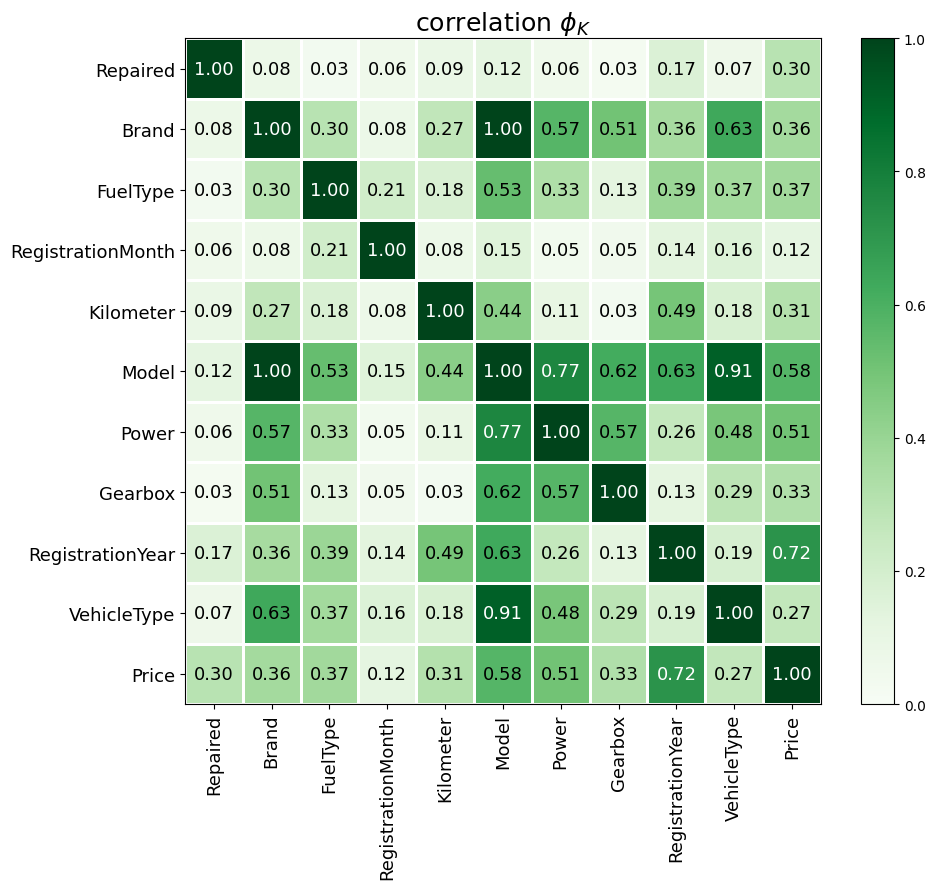

In [11]:
interval_cols = num_col
avto_df[cat_col] = avto_df[cat_col].astype('category')
# 'PHIK матрица'
display ('PHIK матрица ')

phik_overview = avto_df.phik_matrix( interval_cols=interval_cols)#,n_jobs=-1)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.3,
    figsize=(10,9))

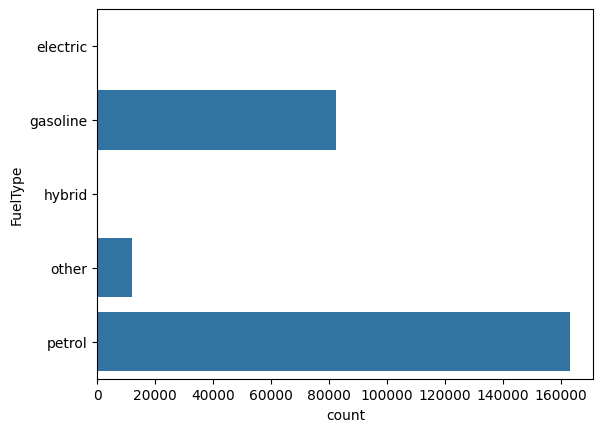

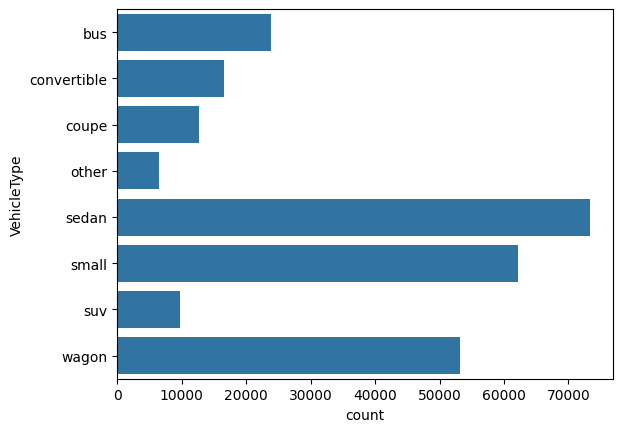

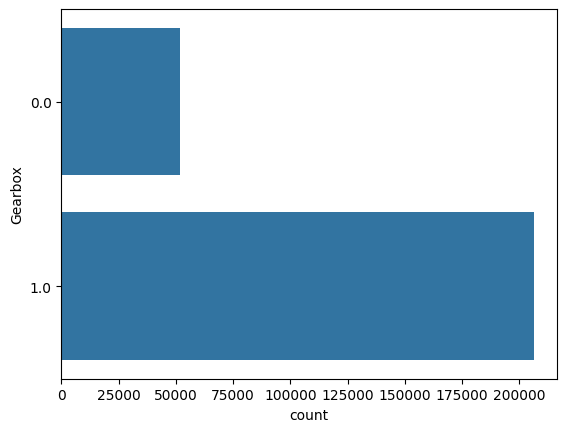

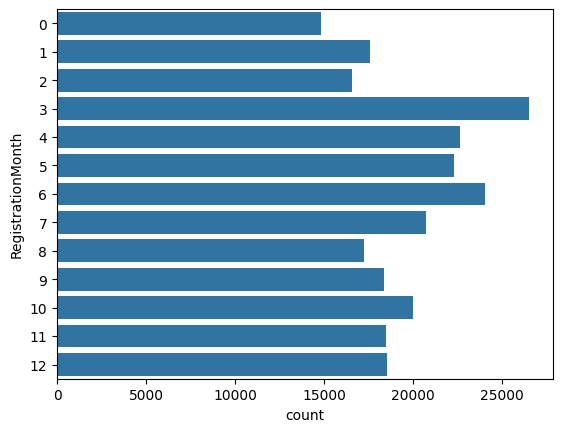

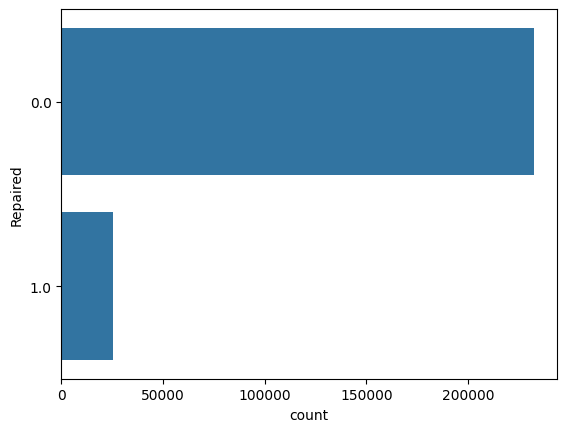

'Price'

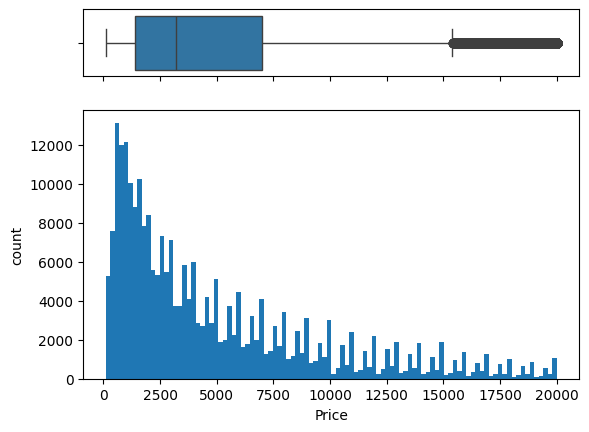

'RegistrationYear'

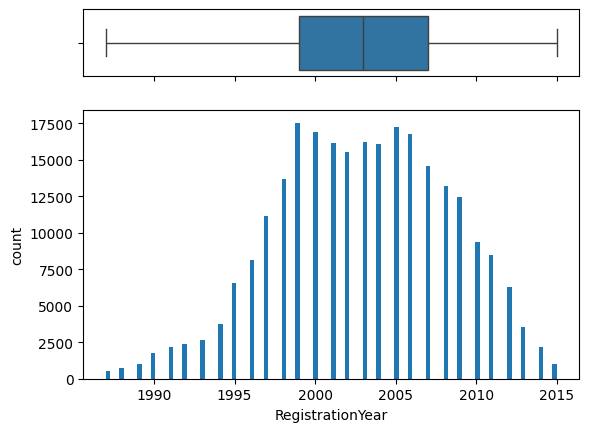

'Power'

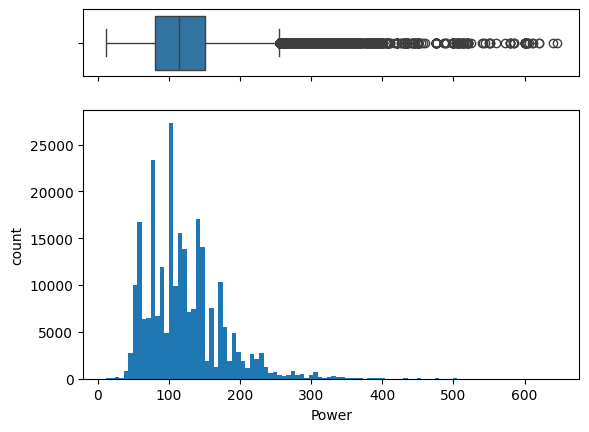

'Kilometer'

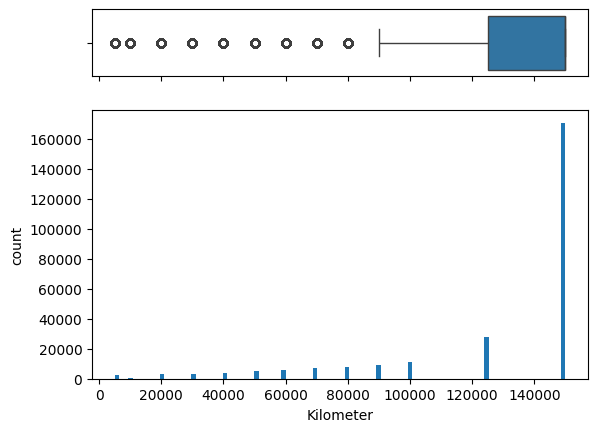

In [12]:
for i in cat_col:
    if avto_df[i].nunique()<20:
        sns.countplot(y=i, data=avto_df)
        plt.show()

for n in num_col:
    display(n)
    fig, (ax_box, ax_hist) = plt.subplots(2,sharex = True,gridspec_kw = {'height_ratios': (.20, .80)})
    sns.boxplot(x = avto_df[n], ax = ax_box)
    plt.hist(avto_df[n],bins=100)
    ax_box.set(xlabel = '')
    ax_hist.set(xlabel = n)
    ax_hist.set(ylabel = 'count')
    plt.show()




#### Выводы и план по обработке данных
- Model и Brand имеют корреляцию = 1, значит несут в себе "дублирующий" смысл. Поскольку у Brand меньше значения коэфициентов с другими признами - удаляяем его.
- заполнить все "пустые" значения типом "other" . Выбор определен тем, что танный "непонятный"("неопределенный") класс присутсвует в свойствах "FuelType" "VihicleType"
- установим границы по мощности (40-650) л.с.
- установим границы по цене (100)
- авто с FuelType = cng  lng - преобразовываем в gasoline
- удалим данные с месяцем = 0
- установим границы по году : раз выгрузка было в 2016 - удаляем года после 2016, и удаляем авто старше 30 лет
- удалим дубликаты

### Выводы
- предобработка прошла успешно, оставлены более реалистичные данные

## Обучение моделей

### Подготовка данных

In [13]:
avto_df[cat_col] = avto_df[cat_col].astype('string')
pd.DataFrame.iteritems = pd.DataFrame.items
cat_col = ['Model','FuelType','VehicleType','Gearbox','RegistrationMonth','Repaired']

X=avto_df.drop(['Price','Brand'],axis=1).copy()
y=avto_df['Price'].copy()
# разделение данных на тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)


In [14]:
# фукция параметров кросвалидации моделей
def cv_model(clf,X_train,y_train):
    ohe_columns=['Model','FuelType','VehicleType','Gearbox','RegistrationMonth','Repaired']
    num_columns=['RegistrationYear','Power','Kilometer']


    # создаём общий пайплайн для подготовки данных ,verbose_feature_names_out=True
    data_preprocessor = ColumnTransformer(
        [('ohe', OneHotEncoder(drop='first',handle_unknown='ignore'), ohe_columns), #,handle_unknown='ignore'
         ('num', StandardScaler(), num_columns)
         ],
        remainder='passthrough')


    param_grid = {}
    if clf.__class__.__name__ == 'SVR' :
        param_grid = {'models__C':np.arange(0.1, 1.2, 0.4) }

    elif clf.__class__.__name__ == 'Ridge' :
        param_grid = {'models__alpha': np.arange(0.3, 1, 0.1)}


    else  : param_grid = {}
    pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models',clf)])
    GridCV = GridSearchCV(
        pipe_final,
        param_grid=param_grid,
        cv=3,
        scoring='neg_root_mean_squared_error',
        error_score='raise',
        verbose=False,
        n_jobs=-1
    )
    GridCV.fit(X_train, y_train)
    clf_descr = clf.__class__.__name__

    print()
    print(clf_descr)

    print(f"best parames :   {GridCV.best_params_}")

    results = GridCV.cv_results_
    best_index = GridCV.best_index_

    fit_time = results['mean_fit_time'][best_index]
    score_time = results['mean_score_time'][best_index]
    RMSE = results['mean_test_score'][best_index] * -1

    print(f"Fit time: {fit_time}, Predict time: {score_time}, Best RMSE: {RMSE}")

    #print(f"best score :   {-GridSCV.best_score_}")

    return (clf_descr, RMSE, fit_time,score_time)

In [15]:
def cross_m (X_tr,y_train):
    results = []
    for clf in (
        (DummyRegressor()),
        (LogisticRegression(C=0.01, max_iter=500)),
        (Ridge(max_iter=300,random_state=RANDOM_STATE)),#,solver="sparse_cg")),
        (KNeighborsRegressor(n_neighbors=80)),
        (LinearRegression(n_jobs=-1)),

        (RandomForestRegressor(warm_start=True,random_state=RANDOM_STATE)),
        (SVR(max_iter=300)), #,cache_size=8000,gamma='auto',probability=True,
        (SGDRegressor( alpha=1e-4, n_iter_no_change=3, early_stopping=True)),
        (PassiveAggressiveRegressor()),

        (CatBoostRegressor(iterations=1000, learning_rate=0.001, depth=6,
                            loss_function='RSME',
                            random_seed = RANDOM_STATE,
                            early_stopping_rounds = 400,
                            allow_writing_files=False,
                            verbose= False))
    ):
        print("=" * 80)


        results.append(cv_model(clf,X_tr,y_train) )
    return results

In [17]:
results_model = cross_m(X_train,y_train)


DummyRegressor
best parames :   {}
Fit time: 0.5445110003153483, Predict time: 0.22347140312194824, Best RMSE: 4614.346074287126


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}
Detailed tracebacks of the workers should have been printed to stderr in the executor process if faulthandler was not disabled.

In [ ]:
ohe_columns=['Model','FuelType','VehicleType','Gearbox','RegistrationMonth','Repaired']
num_columns=['RegistrationYear','Power','Kilometer']

clf = LogisticRegression(C=0.01, max_iter=500)
# создаём общий пайплайн для подготовки данных ,verbose_feature_names_out=True
data_preprocessor = ColumnTransformer(
        [('ohe', OneHotEncoder(drop='first'), ohe_columns), #,handle_unknown='ignore'
         ('num', MinMaxScaler(), num_columns)
         ],
        remainder='passthrough')
pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models',clf)])

mod1 = pipe_final.fit(X_train,y_train)

mod1.predict (X_train)

In [ ]:
%time
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', Ridge(random_state=RANDOM_STATE,alpha=0.9, max_iter=300, tol=0.1))])

model_reg=pipe_final
model_reg.fit(X_train,y_train)

In [ ]:
# важность признаков
y_pred=model_reg.predict(X_train)

RSME_reg=np.sqrt(mean_squared_error(y_train,y_pred))
display (RSME_reg)


features = X_train.columns
importance_values = model_reg['models'].coef_[0]
plt.barh(y=range(len(features)),
         width=importance_values,
         tick_label=features)
plt.show()

#report = classification_report(y_train, y_pred)
#print(report)

### построение модели Catboost с наилучшими параметрами

In [ ]:
# Catboost валидация

df_auto[cat_col]=df_auto[cat_col].astype('category')
X_train=df_auto.drop('Price',axis=1)
y_train=df_auto['Price']
data_pool = Pool(features_train,target_train, cat_features= cat_col)
model = CatBoostRegressor(loss_function='RMSE',
                          verbose=False,
                          subsample=0.6,
                          iterations=300) #,iterations=400

param_grid = {'learning_rate': np.arange(0.05, 0.063,0.002),
        'depth': range(1, 10),
        #'l2_leaf_reg': range(1,2),

        'min_data_in_leaf':range(1,5)
       }

grid_search_result = model.grid_search(param_grid,
                                       data_pool,
                                       early_stopping_rounds=10,
                                      )

display (grid_search_result['params'])
display(model.get_best_score())

In [ ]:
display (grid_search_result['params'])

feature_importance=model.get_feature_importance(prettified=True)
display(feature_importance)
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=feature_importance,x=feature_importance['Importances'],
                 y=feature_importance['Feature Id'])
ax.set_title('Важность признаков', fontsize=16)
plt.show()
print(model.get_best_score())



In [ ]:
%time
model_best_cat =model
model_best_cat.fit(data_pool)

### построение модели LGBM с наилучшими параметрами

In [ ]:
model = LGBMRegressor(metric='neg_root_mean_squared_error',
                      random_state=RANDOM_STATE,
                      verbose= 0)

cv = StratifiedKFold(n_splits=5)
#cv = RepeatedStratifiedKFold(n_splits=10000, n_repeats=3, random_state=1)
model.fit(X_train, y_train,categorical_feature=cat_col)
n_scores = cross_val_score(model, X_train, y_train,
                           scoring='neg_root_mean_squared_error',
                           cv=cv, n_jobs=-1, error_score='raise')



print('RMSE:',(-max(n_scores)))

print('наилучшие параметры',model.get_params())


In [ ]:
best_model_LGBM =model#(model.best_estimator_)

# Plot feature importances
features = X_train.columns
importance_values = best_model_LGBM.feature_importances_
plt.barh(y=range(len(features)),
         width=importance_values,
         tick_label=features)
plt.show()



In [ ]:
%time


best_model_LGBM.fit(X_train, y_train)
%time

In [ ]:
# лучшая модель по метрике оказалась LGBM
%time
RSME_cat=np.sqrt(mean_squared_error(y_test, model_best_cat.predict(X_test)))
display (RSME_cat)


## Анализ моделей

- время выполнения лучше у Ridge 5.48 милсек
- целевое качество метрики RMSE достигнуто на всех моделях, у catboost лучшая =1519.56
- рекомендуемые модели для обучения Catboost и LGBM
- разные модели показали не одинаковую значимость признаков,
  но "тройка лидеров" у всех одна- ( "RegistrationYear", "Power", "Вrand")

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b>

Есть еще один вариант измерить время обучения и предсказания моделей, сделав это прямо в кросс-валидации:
    
```
results_ridge = gs_ridge.cv_results_
best_index_ridge = gs_ridge.best_index_

ridge_fit_time = results_ridge['mean_fit_time'][best_index_ridge]
ridge_score_time = results_ridge['mean_score_time'][best_index_ridge]
ridge_RMSE = results_ridge['mean_test_score'][best_index_ridge] * -1

print(f"Fit time: {ridge_fit_time}, Predict time: {ridge_score_time}, Best RMSE: {ridge_RMSE}")

   
```

Или вообще просто:

берем `result = pd.DataFrame(randomized_search.cv_results_)`, уточняем, какие колонки нам нужны, оставляем модели, параметры, время обучения, время предсказания.
       
***
    
Тогда если мы попробуем реализовать пайплайн по подобию пайплайна из спринта по Обучению с учителем, где у нас перебираются несколько моделей и их параметры, то из этого пайплайна сразу получим время обучения и предсказания, а также качество всех моделей по просс-валидации.
    
Все будет компактно, после этого просто допроверим качество на тестовой выборке.
    
Но вполне верным решением будет и делать обучение для каждой модели отдельно.
        
</div>
